# Net2Net Paper Replication (https://arxiv.org/pdf/1511.05641)

making Student network to represent the Teacher network's function


## Net2WiderNet

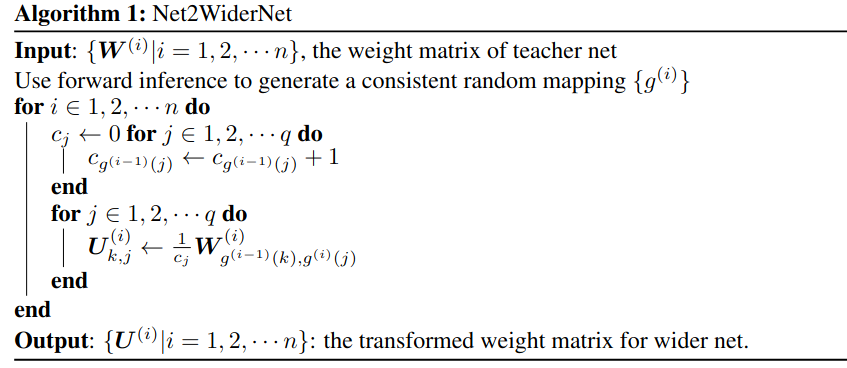
```
n = len(networks)
q = output size of a net
i = 1,...,n
j = 1,...,q

c holds the count of the sampled output nodes

g(j) = j if j<=n else random.choice{1,...,n}
```

In [1]:
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split

N_samples = 1000
COL_DOMAINS = [(-10,10),(21,78), (1, 2000), (-1000,12)]
X = torch.vstack([torch.linspace(x,y,N_samples) for x,y in  COL_DOMAINS]).T
def mystery_function(X):
    return torch.cos(X).mean(axis=1)  + torch.rand(len(X)) *.2
    
y = mystery_function(X).reshape(-1,1)

In [2]:
dataset = TensorDataset(X,y)
train_size = int(0.8 * N_samples)
test_size = N_samples - train_size
batch_size = 32

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
import torch.nn as nn

class SimpleNN(nn.Module):
    def __init__(self, hidden: list, input_c: int = 4, output_c: int = 1):
        super(SimpleNN, self).__init__()

        
        self.layers =  nn.ModuleList()
        prev = input_c
        for hc in hidden:
            self.layers.append(
                nn.Linear(prev, hc,bias=False)
            )
            prev = hc
        # Final output layer
        self.layers.append( nn.Linear(prev, output_c,bias=False))
        
        
        self._layer_count = len(self.layers)-1
        

    def forward(self, x):
        for i in range(self._layer_count+1):
            x = self.layers[i](x)
            if i < self._layer_count:
                x = nn.functional.relu(x)
        return x


import random
def random_map_to_teacher(j, n) -> int:
    if j<n: 
        return j
    return random.randint(0,n-1)

def net2widernet(teacher: SimpleNN, student: SimpleNN):
    """
    Transfer teacher weights to wide student net
    """
    N = teacher._layer_count # dont transform the last layer

    for i in range(N):
        q = student.layers[i].weight.data.shape[0] # outputs of the student layer_i
        n = teacher.layers[i].weight.data.shape[0] # outputs of the teacher layer_i

        # Computing mappings and teacher neuron use counts
        mapping_g = [-1]*q
        count = [0]*n
        for j in range(q):
            outneuron = random_map_to_teacher(j, n)
            count[outneuron]+=1
            mapping_g[j] = outneuron

        # Initializing student weights U
        # print(i, count, mapping_g)
        count = torch.tensor(count)
        student.layers[i].weight.data[:, :] = (1/count[mapping_g]).reshape(-1,1) * teacher.layers[i].weight.data[mapping_g]

In [4]:
import torch.optim as optim

teacher_net = SimpleNN([10])
student_net = SimpleNN([20])

criterion = nn.MSELoss()

In [5]:
# Check
# net2widernet(teacher_net,student_net)
# i= 1
# student_net.layers[i].weight.data == teacher_net.layers[i].weight.data

In [6]:
def train(model, num_epochs = 100,lr=0.01):
    optimizer = optim.SGD(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            loss.backward()
            optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [7]:
def evaluate(model):

    model.eval()
    with torch.no_grad(): 
        test_loss = 0
        for batch_X, batch_y in test_loader:
            predictions = model(batch_X)
            test_loss += criterion(predictions, batch_y).item()
        
        test_loss /= len(test_loader)
        print(f'\nTest Loss: {test_loss:.4f}')

In [8]:
evaluate(teacher_net) # before training


Test Loss: 13450.3767


In [9]:
train(teacher_net,10,0.01)

Epoch [10/10], Loss: 0.1363


In [10]:
evaluate(teacher_net) # after training


Test Loss: 0.1571


In [11]:
evaluate(student_net) # Before weight initilaization
net2widernet(teacher_net, student_net)
evaluate(student_net)


Test Loss: 59532.1473

Test Loss: 0.1571


In [12]:
train(student_net,30)

Epoch [10/30], Loss: 0.1606
Epoch [20/30], Loss: 0.1471
Epoch [30/30], Loss: 0.1685


In [13]:
evaluate(student_net)


Test Loss: 0.1571


# Net2DeeperNet

instead of $h^{(i)} = \phi(h^{(i-1)T} W^{(i)})$ we add another layer $U$ to make it deeper: 
$$
h^{(i)} = \phi(U^{(i)T} \phi(W^{(i)T} h^{(i-1)} ))
$$

here the $U$ is identity matrix (learnable)